In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from matplotlib import pyplot as plt

In [2]:
matches_df = pd.read_csv('matches.csv', index_col = 0)

In [3]:
matches_df.head()

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,dist,fk,pk,pkatt,pkatt.1,npxg/sh,g-xg,np:g-xg,season,team
1,2022-08-07,16:30,Premier League,Matchweek 1,Sun,Away,W,2,0,West Ham,...,18.7,1.0,1.0,1.0,1.0,0.11,-0.2,-0.4,2023,Manchester City
2,2022-08-13,15:00,Premier League,Matchweek 2,Sat,Home,W,4,0,Bournemouth,...,17.5,0.0,0.0,0.0,0.0,0.09,1.3,1.3,2023,Manchester City
3,2022-08-21,16:30,Premier League,Matchweek 3,Sun,Away,D,3,3,Newcastle Utd,...,16.2,1.0,0.0,0.0,0.0,0.10,0.9,0.9,2023,Manchester City
4,2022-08-27,15:00,Premier League,Matchweek 4,Sat,Home,W,4,2,Crystal Palace,...,14.1,0.0,0.0,0.0,0.0,0.13,1.8,1.8,2023,Manchester City
5,2022-08-31,19:30,Premier League,Matchweek 5,Wed,Home,W,6,0,Nott'ham Forest,...,14.8,0.0,0.0,0.0,0.0,0.20,2.7,2.7,2023,Manchester City


In [4]:
matches_df.dtypes

date             object
time             object
comp             object
round            object
day              object
venue            object
result           object
gf                int64
ga                int64
opponent         object
xg              float64
xga             float64
poss            float64
attendance      float64
captain          object
formation        object
referee          object
match report     object
notes           float64
sh              float64
sot             float64
dist            float64
fk              float64
pk              float64
pkatt           float64
pkatt.1         float64
npxg/sh         float64
g-xg            float64
np:g-xg         float64
season            int64
team             object
dtype: object

In [5]:
del matches_df["comp"]
del matches_df["notes"]

In [6]:
matches_df["team"].value_counts()

Manchester City             114
Crystal Palace              114
Southampton                 114
Leeds United                114
Leicester City              114
Everton                     114
West Ham United             114
Arsenal                     114
Chelsea                     114
Wolverhampton Wanderers     114
Tottenham Hotspur           114
Aston Villa                 114
Brighton and Hove Albion    114
Liverpool                   114
Newcastle United            114
Manchester United           114
Fulham                       76
Brentford                    76
Burnley                      76
Bournemouth                  38
Nottingham Forest            38
Watford                      38
Norwich City                 38
West Bromwich Albion         38
Sheffield United             38
Name: team, dtype: int64

In [7]:
matches_df["opponent"].value_counts()

West Ham           114
Liverpool          114
Everton            114
Leeds United       114
Arsenal            114
Manchester City    114
Leicester City     114
Brighton           114
Southampton        114
Tottenham          114
Manchester Utd     114
Wolves             114
Aston Villa        114
Crystal Palace     114
Newcastle Utd      114
Chelsea            114
Burnley             76
Fulham              76
Brentford           76
Bournemouth         38
Norwich City        38
Nott'ham Forest     38
Watford             38
Sheffield Utd       38
West Brom           38
Name: opponent, dtype: int64

In [8]:
matches_df["date"] = pd.to_datetime(matches_df["date"])

In [9]:
matches_df["venue_code"] = matches_df["venue"].astype("category").cat.codes

In [10]:
matches_df["opp_code"] = matches_df["opponent"].astype("category").cat.codes

In [11]:
matches_df["hour"] = matches_df["time"].str.replace(":.+", "", regex=True).astype(int)

In [12]:
matches_df["day_code"] = matches_df["date"].dt.dayofweek

In [13]:
matches_df["target"] = (matches_df["result"] == "W").astype("int")

In [14]:
rf = RandomForestClassifier(n_estimators = 50, min_samples_split = 10, random_state = 1)

In [15]:
train = matches_df[matches_df["date"] < '2022-12-31']

In [16]:
test = matches_df[matches_df["date"] > '2022-12-31']

In [17]:
predictors = ["venue_code", "opp_code", "hour", "day_code"]

In [18]:
rf.fit(train[predictors], train["target"])

RandomForestClassifier(min_samples_split=10, n_estimators=50, random_state=1)

In [19]:
preds = rf.predict(test[predictors])

In [20]:
acc = accuracy_score(test["target"], preds)

In [21]:
acc

0.5949074074074074

In [22]:
combined = pd.DataFrame(dict(actual=test["target"], prediction = preds))

In [23]:
pd.crosstab(index=combined["actual"], columns=combined["prediction"])

prediction,0,1
actual,,
0,208,58
1,117,49


In [24]:
precision_score(test["target"], preds)

0.45794392523364486

In [25]:
grouped_matches = matches_df.groupby("team")

In [26]:
group = grouped_matches.get_group("Arsenal").sort_values("date")

In [27]:
def rolling_averages(group, cols, new_cols):
    group = group.sort_values("date")
    rolling_stats = group[cols].rolling(5, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group

In [28]:
cols = ["gf", "ga", "sh", "sot","dist", "fk", "pk", "pkatt", "g-xg"]
        # "npxg/sh", "g-xg", "np:g-xg"]

new_cols = [f"{c}_rolling" for c in cols]

In [29]:
new_cols

['gf_rolling',
 'ga_rolling',
 'sh_rolling',
 'sot_rolling',
 'dist_rolling',
 'fk_rolling',
 'pk_rolling',
 'pkatt_rolling',
 'g-xg_rolling']

In [30]:
rolling_averages(group, cols, new_cols)

,date,time,round,day,venue,result,gf,ga,opponent,xg,...,target,gf_rolling,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling,g-xg_rolling
9,2020-10-25,19:15,Matchweek 6,Sun,Home,L,0,1,Leicester City,0.7,...,0,1.6,1.2,8.2,3.8,15.72,0.8,0.0,0.0,4.400000e-01
11,2020-11-01,16:30,Matchweek 7,Sun,Away,W,1,0,Manchester Utd,1.0,...,1,1.0,1.4,8.0,3.6,15.90,0.6,0.0,0.0,8.000000e-02
13,2020-11-08,19:15,Matchweek 8,Sun,Home,L,0,3,Aston Villa,1.5,...,0,0.8,1.2,7.8,3.2,17.86,0.6,0.2,0.2,-1.000000e-01
14,2020-11-22,16:30,Matchweek 9,Sun,Away,D,0,0,Leeds United,0.9,...,0,0.6,1.2,9.6,3.0,18.14,0.6,0.2,0.2,-3.400000e-01
16,2020-11-29,19:15,Matchweek 10,Sun,Home,L,1,2,Wolves,1.5,...,0,0.2,1.0,10.2,2.4,18.80,1.0,0.2,0.2,-8.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44,2023-05-02,20:00,Matchweek 34,Tue,Home,W,3,1,Chelsea,1.7,...,1,2.4,2.4,12.8,4.2,15.36,0.2,0.2,0.4,2.200000e-01
45,2023-05-07,16:30,Matchweek 35,Sun,Away,W,2,0,Newcastle Utd,1.3,...,1,2.2,2.4,13.6,5.2,15.18,0.2,0.0,0.2,4.400000e-01
46,2023-05-14,16:30,Matchweek 36,Sun,Home,L,0,3,Brighton,0.9,...,0,2.2,2.0,13.8,5.4,15.36,0.2,0.0,0.2,2.600000e-01
47,2023-05-20,17:30,Matchweek 37,Sat,Away,L,0,1,Nott'ham Forest,0.6,...,0,1.8,2.2,14.6,4.8,15.86,0.2,0.0,0.0,2.200000e-01


In [31]:
matches_rolling = matches_df.groupby("team").apply(lambda x: rolling_averages(x, cols, new_cols))

In [32]:
matches_rolling = matches_rolling.droplevel("team")

In [33]:
matches_rolling.index = range(matches_rolling.shape[0])

In [34]:
matches_rolling

,date,time,round,day,venue,result,gf,ga,opponent,xg,...,target,gf_rolling,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling,g-xg_rolling
0,2020-10-25,19:15,Matchweek 6,Sun,Home,L,0,1,Leicester City,0.7,...,0,1.6,1.2,8.2,3.8,15.72,0.8,0.0,0.0,0.44
1,2020-11-01,16:30,Matchweek 7,Sun,Away,W,1,0,Manchester Utd,1.0,...,1,1.0,1.4,8.0,3.6,15.90,0.6,0.0,0.0,0.08
2,2020-11-08,19:15,Matchweek 8,Sun,Home,L,0,3,Aston Villa,1.5,...,0,0.8,1.2,7.8,3.2,17.86,0.6,0.2,0.2,-0.10
3,2020-11-22,16:30,Matchweek 9,Sun,Away,D,0,0,Leeds United,0.9,...,0,0.6,1.2,9.6,3.0,18.14,0.6,0.2,0.2,-0.34
4,2020-11-29,19:15,Matchweek 10,Sun,Home,L,1,2,Wolves,1.5,...,0,0.2,1.0,10.2,2.4,18.80,1.0,0.2,0.2,-0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2145,2023-04-29,15:00,Matchweek 34,Sat,Away,L,0,6,Brighton,0.8,...,0,1.4,0.6,10.4,3.8,19.50,0.4,0.2,0.2,0.36
2146,2023-05-06,15:00,Matchweek 35,Sat,Home,W,1,0,Aston Villa,0.8,...,1,1.2,1.6,10.8,4.0,19.80,0.4,0.2,0.2,0.10
2147,2023-05-13,15:00,Matchweek 36,Sat,Away,L,0,2,Manchester Utd,0.3,...,0,1.2,1.6,10.2,3.6,18.48,0.4,0.2,0.2,0.06
2148,2023-05-20,15:00,Matchweek 37,Sat,Home,D,1,1,Everton,1.6,...,0,0.8,2.0,9.0,1.8,16.90,0.4,0.2,0.2,-0.24


In [35]:
def make_predictions(data, predictors):
    train = data[data["date"] < '2022-12-31']
    test = data[data["date"] > '2022-12-31']
    rf.fit(train[predictors], train["target"])
    preds = rf.predict(test[predictors])
    combined = pd.DataFrame(dict(actual=test["target"], predicted=preds), index=test.index)
    precision = precision_score(test["target"], preds)
    return combined, precision

In [36]:
combined, precision = make_predictions(matches_rolling, predictors + new_cols)

In [37]:
precision

0.5048543689320388

In [38]:
combined = combined.merge(matches_rolling[["date", "team", "venue", "opponent", "result"]], left_index=True, right_index=True)

In [39]:
combined

,actual,predicted,date,team,venue,opponent,result
87,0,1,2023-01-03,Arsenal,Home,Newcastle Utd,D
88,1,1,2023-01-15,Arsenal,Away,Tottenham,W
89,1,0,2023-01-22,Arsenal,Home,Manchester Utd,W
90,0,1,2023-02-04,Arsenal,Away,Everton,L
91,0,1,2023-02-11,Arsenal,Home,Brentford,D
...,...,...,...,...,...,...,...
2145,0,0,2023-04-29,Wolverhampton Wanderers,Away,Brighton,L
2146,1,0,2023-05-06,Wolverhampton Wanderers,Home,Aston Villa,W
2147,0,0,2023-05-13,Wolverhampton Wanderers,Away,Manchester Utd,L
2148,0,0,2023-05-20,Wolverhampton Wanderers,Home,Everton,D


In [40]:
class MissingDict(dict):
    __missing__ = lambda self, key: key

map_values = {
    "Brighton and Hove Albion": "Brighton",
    "Manchester United": "Manchester Utd",
    "Wolverhampton Wanderers": "Wolves",
    "Newcastle United": "Newcastle Utd",
    "West Ham United": "West Ham",
    "West Bromwich Albion": "West Brom",
    "Nottingham Forest": "Nott'ham Forest",
    "Sheffield United": "Sheffield Utd", 
    "Arsenal": "Arsenal",
    "Manchester City": "Manchester City",
    "Burnley": "Burnley",
    "Leeds United": "Leeds United",
    "Brentford": "Brentford",
    "Everton": "Everton",
    "Southampton": "Southampton",
    "Crystal Palace": "Crystal Palace",
    "Aston Villa": "Aston Villa",
    "Leicester City": "Leicester City",
    "Watford": "Watford",
    "Norwich City": "Norwich City",
    "Chelsea": "Chelsea",
    "Fulham": "Fulham",
    "Liverpool": "Liverpool",
    "Bournemouth": "Bournemouth",
    "Tottenham Hotspur": "Tottenham"
}
mapping = MissingDict(**map_values)

In [41]:
combined['new_team'] = combined['team'].map(map_values)

In [42]:
merged = combined.merge(combined, left_on=["date", "new_team"], right_on=["date", "opponent"])

In [43]:
merged

,actual_x,predicted_x,date,team_x,venue_x,opponent_x,result_x,new_team_x,actual_y,predicted_y,team_y,venue_y,opponent_y,result_y,new_team_y
0,0,1,2023-01-03,Arsenal,Home,Newcastle Utd,D,Arsenal,0,1,Newcastle United,Away,Arsenal,D,Newcastle Utd
1,1,1,2023-01-15,Arsenal,Away,Tottenham,W,Arsenal,0,0,Tottenham Hotspur,Home,Arsenal,L,Tottenham
2,1,0,2023-01-22,Arsenal,Home,Manchester Utd,W,Arsenal,0,1,Manchester United,Away,Arsenal,L,Manchester Utd
3,0,1,2023-02-04,Arsenal,Away,Everton,L,Arsenal,1,0,Everton,Home,Arsenal,W,Everton
4,0,1,2023-02-11,Arsenal,Home,Brentford,D,Arsenal,0,0,Brentford,Away,Arsenal,D,Brentford
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,0,0,2023-04-29,Wolverhampton Wanderers,Away,Brighton,L,Wolves,1,1,Brighton and Hove Albion,Home,Wolves,W,Brighton
428,1,0,2023-05-06,Wolverhampton Wanderers,Home,Aston Villa,W,Wolves,0,1,Aston Villa,Away,Wolves,L,Aston Villa
429,0,0,2023-05-13,Wolverhampton Wanderers,Away,Manchester Utd,L,Wolves,1,1,Manchester United,Home,Wolves,W,Manchester Utd
430,0,0,2023-05-20,Wolverhampton Wanderers,Home,Everton,D,Wolves,0,1,Everton,Away,Wolves,D,Everton


In [44]:
#clean up merge
del merged["team_x"]
del merged["team_y"]

In [45]:
merged.head()

,actual_x,predicted_x,date,venue_x,opponent_x,result_x,new_team_x,actual_y,predicted_y,venue_y,opponent_y,result_y,new_team_y
0,0,1,2023-01-03,Home,Newcastle Utd,D,Arsenal,0,1,Away,Arsenal,D,Newcastle Utd
1,1,1,2023-01-15,Away,Tottenham,W,Arsenal,0,0,Home,Arsenal,L,Tottenham
2,1,0,2023-01-22,Home,Manchester Utd,W,Arsenal,0,1,Away,Arsenal,L,Manchester Utd
3,0,1,2023-02-04,Away,Everton,L,Arsenal,1,0,Home,Arsenal,W,Everton
4,0,1,2023-02-11,Home,Brentford,D,Arsenal,0,0,Away,Arsenal,D,Brentford


In [46]:
merged["new_team_x"].value_counts()

Chelsea            23
Arsenal            22
Tottenham          22
Brighton           22
Crystal Palace     22
Nott'ham Forest    22
Leeds United       22
Aston Villa        22
Liverpool          22
Manchester City    22
Manchester Utd     22
Newcastle Utd      21
West Ham           21
Southampton        21
Leicester City     21
Fulham             21
Everton            21
Brentford          21
Bournemouth        21
Wolves             21
Name: new_team_x, dtype: int64

In [47]:
merged[(merged["predicted_x"] == 0) & (merged["predicted_y"] == 0) & (merged["actual_x"] == 0)]["actual_y"].value_counts()

1    88
0    56
Name: actual_y, dtype: int64

In [48]:
56/(56+88)

0.3888888888888889

When predicting the draw it has a 37.5% chance of being correct

In [49]:
merged[(merged["predicted_x"] == 1) & (merged["predicted_y"] == 0) & (merged["actual_x"] == 0)]["venue_x"].value_counts()

Away    30
Home    16
Name: venue_x, dtype: int64

In [50]:
30/(30+16)

0.6521739130434783

When I predict that x is going to beat y and x either loses or draws, they are normally away

In [51]:
merged[(merged["predicted_x"] == 1) & (merged["predicted_y"] == 0) & (merged["actual_x"] == 1) & (merged["actual_y"] == 0)]["venue_x"].value_counts()

Home    36
Away    15
Name: venue_x, dtype: int64

In [52]:
36/(36+15)

0.7058823529411765

When I predict that x will beat y and x is at home I have a 70% of getting it correct

Check Arsenal Prediction

In [53]:
merged_arsenal = merged[merged['new_team_x'].str.match('Arsenal')]

In [54]:
merged_arsenal

,actual_x,predicted_x,date,venue_x,opponent_x,result_x,new_team_x,actual_y,predicted_y,venue_y,opponent_y,result_y,new_team_y
0,0,1,2023-01-03,Home,Newcastle Utd,D,Arsenal,0,1,Away,Arsenal,D,Newcastle Utd
1,1,1,2023-01-15,Away,Tottenham,W,Arsenal,0,0,Home,Arsenal,L,Tottenham
2,1,0,2023-01-22,Home,Manchester Utd,W,Arsenal,0,1,Away,Arsenal,L,Manchester Utd
3,0,1,2023-02-04,Away,Everton,L,Arsenal,1,0,Home,Arsenal,W,Everton
4,0,1,2023-02-11,Home,Brentford,D,Arsenal,0,0,Away,Arsenal,D,Brentford
5,0,0,2023-02-15,Home,Manchester City,L,Arsenal,1,0,Away,Arsenal,W,Manchester City
6,1,1,2023-02-18,Away,Aston Villa,W,Arsenal,0,0,Home,Arsenal,L,Aston Villa
7,1,0,2023-02-25,Away,Leicester City,W,Arsenal,0,0,Home,Arsenal,L,Leicester City
8,1,0,2023-03-01,Home,Everton,W,Arsenal,0,0,Away,Arsenal,L,Everton
9,1,0,2023-03-04,Home,Bournemouth,W,Arsenal,0,0,Away,Arsenal,L,Bournemouth


In [55]:
def calculate_points(row):
    if row['predicted_x'] == 1 and row['predicted_y'] == 0:
        return 3
    elif row['predicted_x'] == 0 and row['predicted_y'] == 1:
        return 0
    else:
        return 1

merged_arsenal = merged_arsenal.copy()
    
merged_arsenal['points'] = merged_arsenal.apply(calculate_points, axis=1)

In [56]:
merged_arsenal

,actual_x,predicted_x,date,venue_x,opponent_x,result_x,new_team_x,actual_y,predicted_y,venue_y,opponent_y,result_y,new_team_y,points
0,0,1,2023-01-03,Home,Newcastle Utd,D,Arsenal,0,1,Away,Arsenal,D,Newcastle Utd,1
1,1,1,2023-01-15,Away,Tottenham,W,Arsenal,0,0,Home,Arsenal,L,Tottenham,3
2,1,0,2023-01-22,Home,Manchester Utd,W,Arsenal,0,1,Away,Arsenal,L,Manchester Utd,0
3,0,1,2023-02-04,Away,Everton,L,Arsenal,1,0,Home,Arsenal,W,Everton,3
4,0,1,2023-02-11,Home,Brentford,D,Arsenal,0,0,Away,Arsenal,D,Brentford,3
5,0,0,2023-02-15,Home,Manchester City,L,Arsenal,1,0,Away,Arsenal,W,Manchester City,1
6,1,1,2023-02-18,Away,Aston Villa,W,Arsenal,0,0,Home,Arsenal,L,Aston Villa,3
7,1,0,2023-02-25,Away,Leicester City,W,Arsenal,0,0,Home,Arsenal,L,Leicester City,1
8,1,0,2023-03-01,Home,Everton,W,Arsenal,0,0,Away,Arsenal,L,Everton,1
9,1,0,2023-03-04,Home,Bournemouth,W,Arsenal,0,0,Away,Arsenal,L,Bournemouth,1


In [57]:
merged_arsenal["points"].sum()

36

In [58]:
def calculate_points(row):
    if row['predicted_x'] == 1 and row['predicted_y'] == 0:
        return 3
    elif row['predicted_x'] == 0 and row['predicted_y'] == 1:
        return 0
    else:
        return 1

merged = merged.copy()
    
merged['points'] = merged.apply(calculate_points, axis=1)

In [59]:
merged

,actual_x,predicted_x,date,venue_x,opponent_x,result_x,new_team_x,actual_y,predicted_y,venue_y,opponent_y,result_y,new_team_y,points
0,0,1,2023-01-03,Home,Newcastle Utd,D,Arsenal,0,1,Away,Arsenal,D,Newcastle Utd,1
1,1,1,2023-01-15,Away,Tottenham,W,Arsenal,0,0,Home,Arsenal,L,Tottenham,3
2,1,0,2023-01-22,Home,Manchester Utd,W,Arsenal,0,1,Away,Arsenal,L,Manchester Utd,0
3,0,1,2023-02-04,Away,Everton,L,Arsenal,1,0,Home,Arsenal,W,Everton,3
4,0,1,2023-02-11,Home,Brentford,D,Arsenal,0,0,Away,Arsenal,D,Brentford,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,0,0,2023-04-29,Away,Brighton,L,Wolves,1,1,Home,Wolves,W,Brighton,0
428,1,0,2023-05-06,Home,Aston Villa,W,Wolves,0,1,Away,Wolves,L,Aston Villa,0
429,0,0,2023-05-13,Away,Manchester Utd,L,Wolves,1,1,Home,Wolves,W,Manchester Utd,0
430,0,0,2023-05-20,Home,Everton,D,Wolves,0,1,Away,Wolves,D,Everton,0


In [60]:
total_points_per_team = merged.groupby('new_team_x')['points'].sum().reset_index()

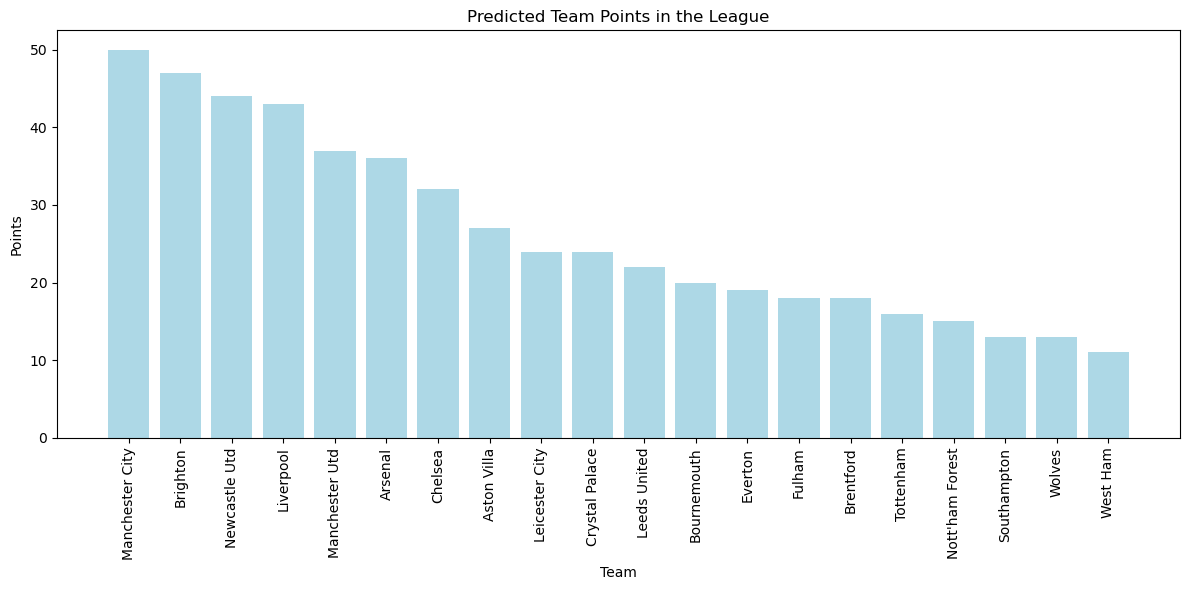

In [61]:
total_points_per_team = total_points_per_team.sort_values(by='points', ascending=False)

# Create the graph
plt.figure(figsize=(12, 6))
plt.bar(total_points_per_team['new_team_x'], total_points_per_team['points'], color='lightblue')
plt.xticks(rotation=90)
plt.xlabel('Team')
plt.ylabel('Points')
plt.title('Predicted Team Points in the League')
plt.tight_layout()

# Display the graph
plt.show()

In [62]:
# 2023 table to see how model is
data = {"Team": ["Manchester City", "Aston Villa", "Manchester Utd", "Arsenal", "Liverpool", "Brighton", "Newcastle", "Brentford", "Tottenham", "Wolves", "Fulham", "West Ham", "Nott'ham Forest", "Crystal Palace", "Bournmouth", "Everton", "Chelsea", "Leicester", "Leeds", "Southampton"],
        "Points": [53, 43, 43, 41, 39, 38, 37, 36, 30, 28, 27, 26, 25, 23, 23, 21, 20, 17, 15, 13]}
        

In [63]:
real_points = pd.DataFrame(data)
real_points = real_points.reset_index(drop=True)

In [64]:
real_points

,Team,Points
0,Manchester City,53
1,Aston Villa,43
2,Manchester Utd,43
3,Arsenal,41
4,Liverpool,39
5,Brighton,38
6,Newcastle,37
7,Brentford,36
8,Tottenham,30
9,Wolves,28


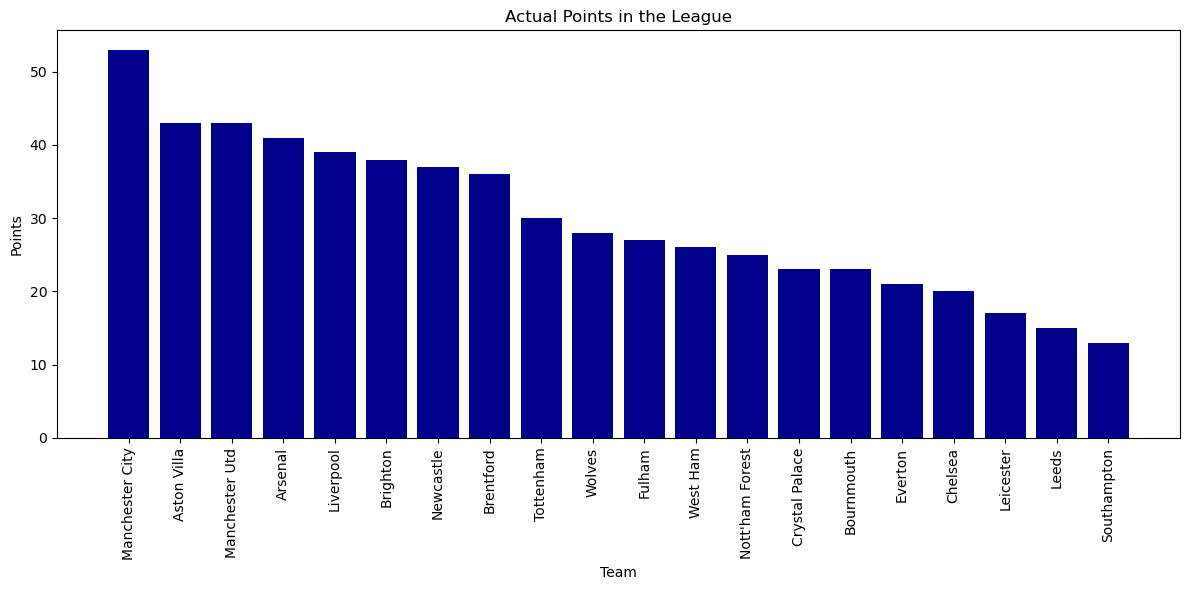

In [65]:
real_points = real_points.sort_values(by='Points', ascending=False)

# Create the graph
plt.figure(figsize=(12, 6))
plt.bar(real_points['Team'], real_points['Points'], color='darkblue')
plt.xticks(rotation=90)
plt.xlabel('Team')
plt.ylabel('Points')
plt.title('Actual Points in the League')
plt.tight_layout()

# Display the graph
plt.show()

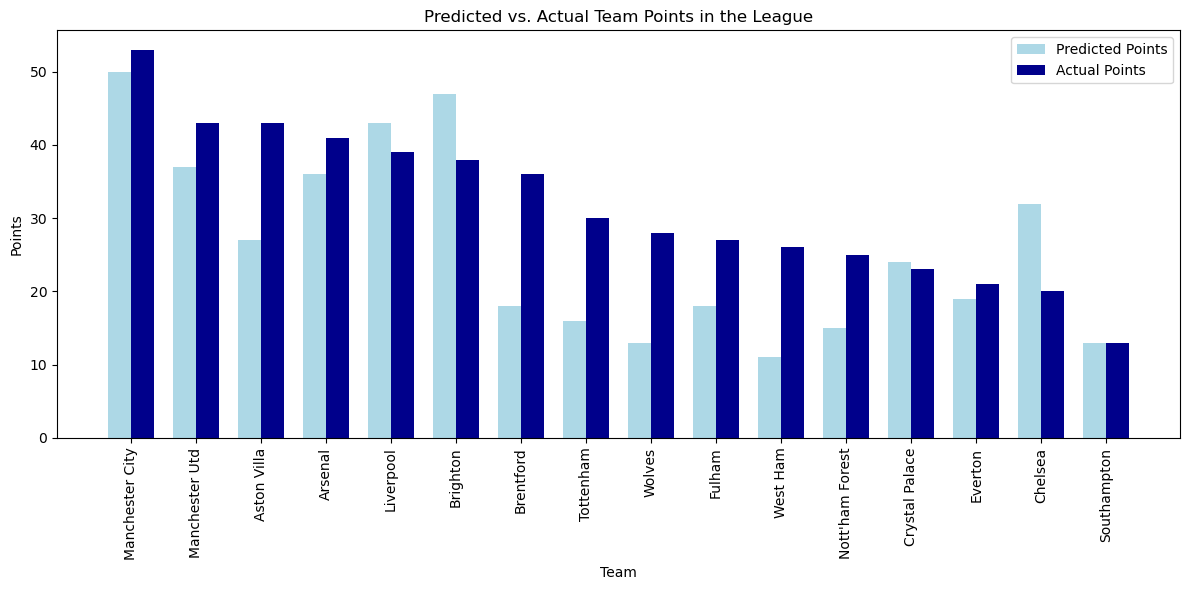

In [66]:
# Assuming you have the DataFrames total_points_per_team and real_points
# Rename the 'new_team_x' column in the total_points_per_team DataFrame to match the column in real_points
total_points_per_team = total_points_per_team.rename(columns={'new_team_x': 'Team'})

# Merge the DataFrames based on the 'Team' column
combined_points = pd.merge(total_points_per_team, real_points, on='Team', suffixes=('_predicted', '_actual'))

# Sort the DataFrame by 'Points' in ascending order (actual points)
combined_points = combined_points.sort_values(by='Points', ascending=False)

# Create a single figure and axes for both graphs
fig, ax = plt.subplots(figsize=(12, 6))

# Set the width of each bar
bar_width = 0.35

# Calculate the center position for the bars
bar_positions = range(len(combined_points['Team']))

# Plot the bars for predicted points (light blue) with an offset to the left
ax.bar(bar_positions, combined_points['points'], color='lightblue', width=bar_width, label='Predicted Points')

# Plot the bars for actual points (dark blue) with an offset to the right
ax.bar([pos + bar_width for pos in bar_positions], combined_points['Points'], color='darkblue', width=bar_width, label='Actual Points')

# Set x-axis tick positions and labels at the center of each group of bars
ax.set_xticks([pos + bar_width / 2 for pos in bar_positions])
ax.set_xticklabels(combined_points['Team'], rotation=90)

# Set labels and title
ax.set_xlabel('Team')
ax.set_ylabel('Points')
ax.set_title('Predicted vs. Actual Team Points in the League')

# Show legend
ax.legend()

# Adjust layout and display the graph
plt.tight_layout()
plt.show()